In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,Input,Dropout,MaxPooling2D
from tensorflow.keras import datasets, layers, models
from tensorflow.math import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB4, Xception, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import random
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
df.shape

(10222, 2)

In [6]:
df["breed"].nunique()

120

In [7]:
df["breed"].unique()

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'borde

In [8]:
df.isna().sum()

id       0
breed    0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [10]:
df.shape

(10222, 2)

In [11]:
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [12]:
def read_and_resize_image_rgb(file_path):
    img = cv2.imread(file_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_rgb_resized = cv2.resize(img_rgb, (224, 224))
    return img_rgb_resized

In [13]:
image_dir = 'drive/MyDrive/dog/train'

In [16]:
resized_images = []
for idx, filename in enumerate(df['id']):
    img_path = os.path.join(image_dir, filename + '.jpg')
    resized_img = read_and_resize_image_rgb(img_path)
    resized_images.append(resized_img)
resized_images_array = np.array(resized_images)

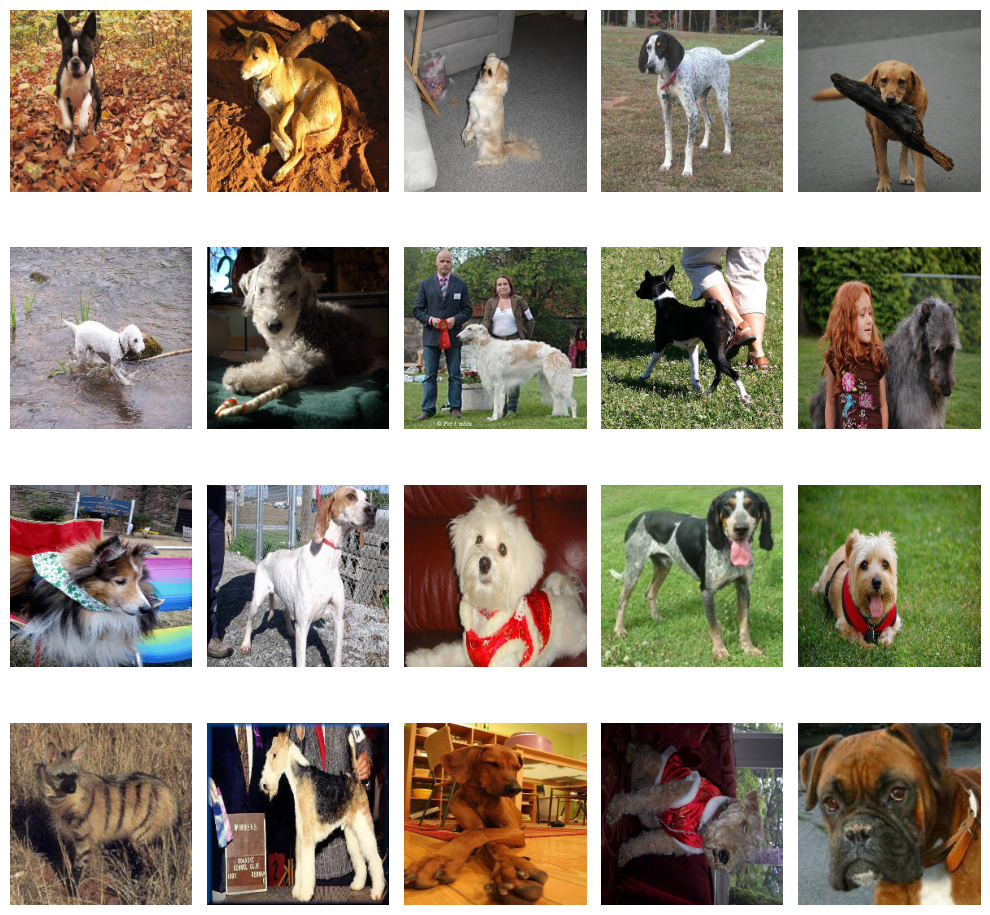

In [17]:
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(resized_images_array[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [18]:
class_names = df['breed'].unique()
class_names[1:10]

array(['dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog'], dtype=object)

In [19]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(df['breed'])
new_labels = to_categorical(label_encoded)

In [20]:
X = resized_images_array
y = new_labels

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=30)

In [22]:
X_train.shape

(8688, 224, 224, 3)

In [23]:
X_test.shape

(1534, 224, 224, 3)

In [24]:
y_train.shape

(8688, 120)

In [25]:
y_test.shape

(1534, 120)

In [26]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)

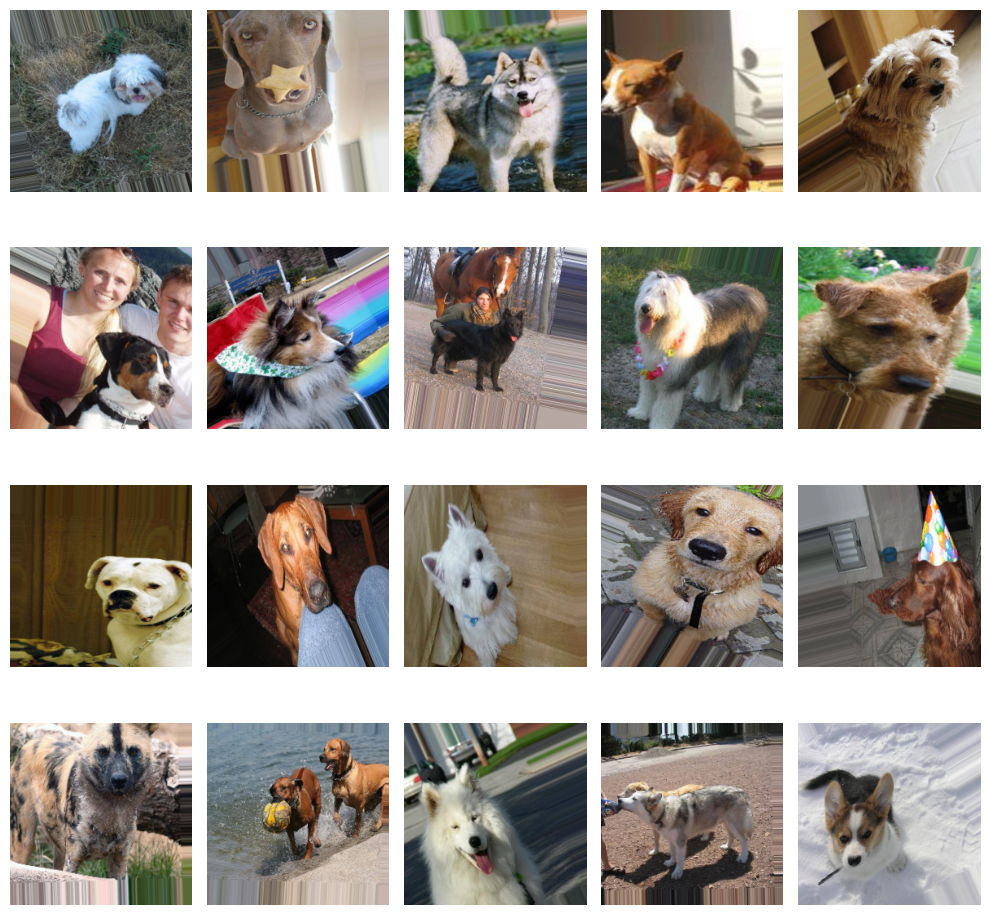

In [27]:
augmented_images = train_datagen.flow(X_train, y=y_train, shuffle=True)
plt.figure(figsize=(10, 10))
for i in range(20):
    augmented_image = augmented_images.next()[0][0]
    plt.subplot(4, 5, i + 1)
    plt.imshow(augmented_image)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
training_set=train_datagen.flow(X_train,y=y_train,batch_size=64)
testing_set=test_datagen.flow(X_test,y=y_test,batch_size=64)

In [30]:
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(8, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='sigmoid'),
    Dropout(0.2),
    Dense(20, activation='softmax')
])

In [31]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 32)        0

In [46]:
history=model.fit_generator(training_set,validation_data = testing_set,epochs = 20)

Epoch 1/20


InvalidArgumentError: ignored

In [39]:
df = pd.read_csv('labels.csv')
df.shape

(10222, 2)

In [40]:
def read_and_resize_image_rgb(file_path):
    img = cv2.imread(file_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_rgb_resized = cv2.resize(img_rgb, (224, 224))
    return img_rgb_resized

In [41]:
resized_images = []
for idx, filename in enumerate(df['id']):
    img_path = os.path.join(image_dir, filename + '.jpg')
    resized_img = read_and_resize_image_rgb(img_path)
    resized_images.append(resized_img)
resized_images_array = np.array(resized_images)

In [47]:
class_names = df['breed'].unique()

In [48]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(df['breed'])
new_labels = to_categorical(label_encoded)

In [49]:
X = resized_images_array
y = new_labels

In [50]:
def get_features(model_name, model_preprocessor, input_size, data):
    input_layer = Input(input_size)
    preprocessor = model_preprocessor(input_layer)
    base_model = model_name(weights='imagenet', include_top=False, input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs=input_layer, outputs=avg)
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape:', feature_maps.shape)
    return feature_maps

In [ ]:
effnet_preprocessor = tf.keras.applications.efficientnet.preprocess_input
effnet_features = get_features(EfficientNetB4, effnet_preprocessor, (224, 224, 3), X)

xception_preprocessor = tf.keras.applications.xception.preprocess_input
xception_features = get_features(Xception, xception_preprocessor, (224, 224, 3), X)

resnet_preprocessor = tf.keras.applications.resnet50.preprocess_input
resnet_features = get_features(ResNet50, resnet_preprocessor, (224, 224, 3), X)

320/320 [==============================] - 1923s 6s/step
Feature maps shape: (10222, 1792)
83683744/83683744 [==============================] - 4s 0us/step


In [1]:
final_features = np.concatenate([effnet_features, xception_features, resnet_features], axis=-1)
print('Final feature maps shape:', final_features.shape)

NameError: ignored

In [2]:
model = Sequential()
model.add(Dropout(0.5, input_shape=(final_features.shape[1],)))
model.add(Dense(120, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

NameError: ignored

In [84]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [90]:
history = model.fit(final_features, y,
                    batch_size=128,
                    epochs=50,
                    validation_split=0.15,
                    callbacks=[checkpoint, early_stopping])

NameError: ignored

In [ ]:
best_model = load_model('best_model.h5')

In [ ]:
all_predictions = best_model.predict(final_features)
all_predicted_labels = np.argmax(all_predictions, axis=1)
true_labels = np.argmax(y, axis=1)

In [ ]:
random.seed(6)
random_indices = random.sample(range(len(resized_images)), 20)

In [ ]:
def plot_images(images, predicted_labels, true_labels, class_names):
    plt.figure(figsize=(15, 10))
    for i in range(20):
        plt.subplot(4, 5, i + 1)
        plt.imshow(images[i])
        pred_label = predicted_labels[i]
        true_label = true_labels[i]
        if pred_label == true_label:
            title_color = 'green'
        else:
            title_color = 'red'
        plt.title(f"Predicted: {pred_label}\nTrue: {true_label}", color=title_color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
images_random_20 = [resized_images[i] for i in random_indices]
predicted_labels_random_20 = all_predicted_labels[random_indices]
true_labels_random_20 = true_labels[random_indices]

In [ ]:
predicted_labels_names = label_encoder.inverse_transform(predicted_labels_random_20)
true_labels_names = label_encoder.inverse_transform(true_labels_random_20)

In [ ]:
plot_images(images_random_20, predicted_labels_names, true_labels_names, class_names)